# Working with images in python

## array to image to file

Create an image as a set of rgb values in an numpy array, convert it to pil image and write a png. First explore 
the image arrary data structure. To do that we read an image into an PIL image and then convert it to an ndarray. Then we can explore the data layout. Later we build an array and convert it to an image with PIL. Then display that image to see if the pixels end up where we think they will. 


In [1]:
#import stuff and read the image
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
%matplotlib inline
imagefile = os.path.join(os.path.expanduser("~"),"Desktop\lenna.png")
im = Image.open(imagefile)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Dave Semeraro\\Desktop\\lenna.png'

In [3]:
type(im)
imarray = np.array(im)
imarray.shape

(512, 512, 3)

The dimensions of our image array are shown above. It looks like the standard "C" ordering has the pixel rgb values stored as an array of triples by row. The first pixel is:

In [4]:
imarray[0,0]

array([226, 137, 125], dtype=uint8)

The first three pixels in the top row are:

In [5]:
imarray[0,0:3]

array([[226, 137, 125],
       [226, 137, 125],
       [223, 137, 133]], dtype=uint8)

Build an array and morph it into an image. This bit of code builds a 200 by 100 (wxh) image by creating an array of integers 0 < x < 255. It does that by scaling the r,g, and b values linearly with the width and height of the image. Red is scaled from left to right, green is scaled from top to bottom and blue is constant at 0.2 times 255. In order to insure the scaling is correct the calculations are done in floating point and then converted to int by chopping off the remainder. Thus value = float(i)/float(nx)X255.9; 0 <= i <= nx gives i/nx between 0 and 1.0. This leads to 0 <= value <= 255.9. Which gives the correct integer value. Note that the array must be dtype = np.uint8. Using np.int8 is wrong because it is a signed value that goes from -127 - 127.

we need to take care of how the image data is set up. The data is loaded in "C" order or by rows rather than columns. This means for an image that has a width of nx and height of ny we have to create a numpy array with the shape (height,width,colors). This means the rgb values will be contiguous in memory. pixels will be contiguous in the nx direction followed by ny. See the code below for loading index math. Also note that for the image data the zeroth row of the data is displayed at the top of the image. Graphics convention is the origin of the image is at the bottom left corner of the data. This has to be corrected for when loading the array to ensure the image isnt upside down. this could be accomplished when traversing and loading the array or one could use an image transform after the fact.  Again see below for the first method.

In [6]:
nx=200
ny=100
testimagearray = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
maxj = np.arange(ny)[-1]
for j in np.arange(ny):
    g = int(255.9*float(maxj - j)/float(ny)) #flip the y axis. 
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray[j,i] = [r,g,b]

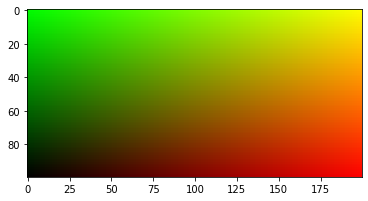

In [9]:
#explore the array
newimage = Image.fromarray(testimagearray)
plt.imshow(newimage)

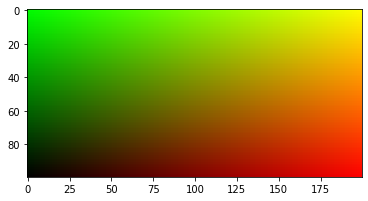

In [7]:
#lets make another test image and flip it using pil rather than programatically
#we should get the same image. 
testimagearray2 = np.zeros((ny,nx,3),dtype=np.uint8)
b = int(255.9*0.0)
for j in np.arange(ny):
    g = int(255.9*float( j)/float(ny))  
    for i in np.arange(nx):
        r = int(255.9*float(i)/float(nx))
        testimagearray2[j,i] = [r,g,b]
# now flip and display
newimage2 = Image.fromarray(testimagearray2)
plt.imshow(ImageOps.flip(newimage2))

Now we want to save the image to a file. Again using pil module. 

In [10]:
# save the first newimage
newimage.save("..\Images\colorblah.png","PNG")

## Image Pixel order. 

We see that the image pixel order in PIL is from top left corner to bottom right. That is pixel rows are counted from top to bottom starting with row 0 and going down to row ny-1. The ordering of columns is from left to right starting with column 0 and ending with column nx-1. The memory storage order is 'C' row major order. Pixels are stored by rows starting from the left edge and running to the right edge row by row. The row major storage order has the column index changing fastest. The pixel in row 'p' and column 'q' of a PIL image is indexed as pixel[q,p] The index on the right (row index) changes fastest in C ordering. Numpy arrays use C row major by default. 

In [11]:
# Get the values of the pixel in the top left corner of the PIL newimage
# the top left should be all green.
print(f'r,g,b {np.array(newimage)[0,0]} {newimage.getpixel((0,0))}')
# the bottim right should be all red
print(f'r,g,b {np.array(newimage)[ny-1,nx-1]} {newimage.getpixel((nx-1,ny-1))}')

r,g,b [  0 253   0] (0, 253, 0)
r,g,b [254   0   0] (254, 0, 0)


The PIL image object itself cant be indexed but it provides a getpixel method that takes a tuple as an index. The indexing order appears to be reversed from that of the underlying numpy array. That is the x index is first and the y index is second in the PIL.image object. The indexing still goes from top left to bottom right. 

All of this is a bit much to keep straight in our heads. We want an image that counts from bottom left to top right. Let the i index range from 0 to nx-1 in the x (horizontal) direction and the j index range from 0 to ny-1 in the y or vertical direction. With i=0,j=0 in the bottom left and i=nx-1 j=ny-1 in the top right corner. Then we want to be able to index the image as ImageObject[i,j] and get the right pixel. ie the one i pixels to the right of the left edge and j pixels up from the bottom edge. In order to accomplish this we create our own image class as a wrapper around the PIL library that indexes things as we like.   

In [12]:
help(newimage)

ted image must match the size of the region.
 |      
 |      If the modes don't match, the pasted image is converted to the mode of
 |      this image (see the :py:meth:`~PIL.Image.Image.convert` method for
 |      details).
 |      
 |      Instead of an image, the source can be a integer or tuple
 |      containing pixel values.  The method then fills the region
 |      with the given color.  When creating RGB images, you can
 |      also use color strings as supported by the ImageColor module.
 |      
 |      If a mask is given, this method updates only the regions
 |      indicated by the mask.  You can use either "1", "L" or "RGBA"
 |      images (in the latter case, the alpha band is used as mask).
 |      Where the mask is 255, the given image is copied as is.  Where
 |      the mask is 0, the current value is preserved.  Intermediate
 |      values will mix the two images together, including their alpha
 |      channels if they have them.
 |      
 |      See :py:meth:`~PIL.I

In [28]:
import numpy as np
class image:
    """
    A numpy based image container. The image resides in a numpy array

    
    """
    def __init__(self,height=100,width=200):
        self._width = width
        self._height = height
        self._data = np.zeros((height,width,3),dtype=np.uint8)
# fix the indexing so the input y index is reversed
# this insures the origin of the image is at the bottom left 
# index wise. 
    def __getitem__(self,key):
        print(f'length of input tuple {len(key)}')
        newkey = self._reverse_height_index(key)
        print(f'{key}')
        print(f'{newkey}')
        return self._data[newkey[0],newkey[1]]
        #return self._data[self._height - key[0] -1,key[1],:]
    def __setitem__(self,key,value):
        self._data[self._height - key[0] -1,key[1]] = value
    @property
    def width(self):
        return self._width
    @property
    def height(self):
        return self._height
    def _reverse_height_index(self,key):
        # this reverses the height index value
        print(key[0].step)
        print(('no','yes')[key[0].step is None])
        
        if isinstance(key[0],slice): # got a slice
            start = self._height - key[0].start -1
            stop = self._height - key[0].stop -1 
            step = (key[0].step,-1)[key[0].step is None]
            print(f'{start}, {stop}, {step}')
            key0 = slice(start,stop,step)
            #key0 = slice(self._height - key[0].start -1,\
            #       self._height - key[0].stop  -1,\
            #       (-(key[0].step),None)[key[0].step is None])
        else:
            key0 = self._height - key[0] - 1
        if len(key) < 3:
            return key0,key[1]
        else:
            return key0,key[1],key[2]

In [29]:
# test image class
scrimage = image()
nx = scrimage.width
ny = scrimage.height
# load up a gradient
scrimage[1,0] = (12,55,38)

In [39]:
print(scrimage[0:2,0:2])

length of input tuple 2
None
yes
99, 97, -1
(slice(0, 2, None), slice(0, 2, None))
(slice(99, 97, -1), slice(0, 2, None))
[[[ 0  0  0]
  [ 0  0  0]]

 [[12 55 38]
  [ 0  0  0]]]
